In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import (DirectTranscription, LinearSystem, LinearQuadraticRegulator, 
                         PiecewisePolynomial, SolutionResult)
A = np.array([[1, 1], [0, 1]])
B = np.array([[0], [1]])
Q = np.identity(2)
R = np.identity(1)

In [21]:
sys = LinearSystem(A,B,np.identity(2),np.zeros((2,1)),0.1)
context = sys.CreateDefaultContext()
kNumTimeSteps = 41  # Note: When this was 21, it converged on a local minima.

In [22]:
prog = DirectTranscription(sys, context, kNumTimeSteps)
K = prog.NewContinuousVariables(1, 2, 'K')
prog.AddConstraintToAllKnotPoints(prog.input()[0] == (-K.dot(prog.state()))[0])
prog.AddRunningCost(prog.state().dot(Q.dot(prog.state())) + prog.input().dot(R.dot(prog.input())))
prog.AddBoundingBoxConstraint([1., 1.], [1., 1.], prog.initial_state())

In [23]:
ret = prog.Solve()
print(prog.GetSolution(K))

[[0.42208242 1.24392872]]


In [24]:
x_trajectory = prog.ReconstructStateTrajectory()
breaks = np.linspace(x_trajectory.start_time(),x_trajectory.end_time(),100)
x_knots = np.hstack([x_trajectory.value(t) for t in breaks])

In [25]:
K_expected = -LinearQuadraticRegulator(sys, Q, R).D()
print(K_expected)

[[0.42208244 1.24392885]]


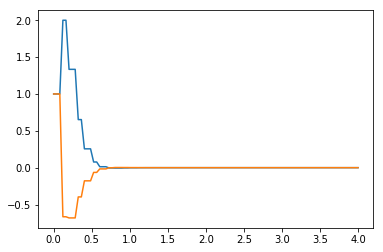

In [26]:
plt.plot(breaks, x_knots[0,:], breaks, x_knots[1,:])